# Simulation of Magnetic Field Effects
- Jeff

Thinking about how to use B field around science cell to detune atoms in tweezers from scattering light from MOT


## MOT Scattering
We want to calculate, in order
1. The scattering rate off of the MOT
2. The intensity of scattered MOT light
3. The intensity of scattered MOT light that reaches the atoms in tweezers
4. The detuning between lightshifted atoms in tweezers + scattered MOT light (gnd state)
5. The scattering rate of the tweezered atoms as a result of MOT light

In [49]:
### Useful functions
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import arc
from get_polarizability import *

# constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K

# Cs information
Cs_D1_wavelength = 894.592959e-9  # Cs D1 line wavelength in meters
Cs_D1_frequency = c / Cs_D1_wavelength  # Cs D1 line frequency in Hz
Cs_D1_gamma = 4.5612e6 # Cs D1 line natural linewidth in Hz
Cs_D1_pi_Isat = 2.4981*10  # Cs D1 line pi-polarized saturation intensity in W/m^2

Cs_D2_wavelength = 852.34727582e-9  # Cs D2 line wavelength in meters
Cs_D2_frequency = c / Cs_D2_wavelength  # Cs D2 line frequency in Hz
Cs_D2_gamma = 5.2227e6 # Cs D2 line natural linewidth in Hz
Cs_D2_pi_Isat = 1.6536*10  # Cs D2 line pi-polarized saturation intensity in W/m^2
Cs_D2_iso_Isat = 2.7059*10  # Cs D2 line isotropic saturation intensity in W/m^2
Cs_D2_sigma_Isat = 1.1023*10  # Cs D2 line sigma-polarized saturation intensity in W/m^2

# Rb information
Rb_D1_wavelength = 794.978850e-9      # Rb D1 line wavelength in meters
Rb_D1_frequency = c / Rb_D1_wavelength  # Rb D1 line frequency in Hz
Rb_D1_gamma = 5.746e6 # Rb D1 line natural linewidth in Hz
Rb_D1_pi_Isat = 4.484*10  # Rb D1 line pi-polarized saturation intensity in W/m^2

Rb_D2_wavelength = 780.241209686e-9  # Rb D2 line wavelength in meters
Rb_D2_frequency = c / Rb_D2_wavelength  # Rb D2 line frequency in Hz
Rb_D2_gamma = 6.065e6 # Rb D2 line natural linewidth in Hz
Rb_D2_pi_Isat = 2.503*10  # Rb D2 line pi-polarized saturation intensity in W/m^2
Rb_D2_iso_Isat = 3.576*10  # Rb D2 line isotropic saturation intensity in W/m^2
Rb_D2_sigma_Isat = 1.669*10  # Rb D2 line sigma-polarized saturation intensity in W/m^2

In [55]:
def calc_scattering_rate(I, I_sat, delta, gamma):
    """
    Calculate the scattering rate of an atom given the laser intensity,
    saturation intensity, detuning, and natural linewidth.

    Parameters:
    I (float): Laser intensity
    I_sat (float): Saturation intensity
    delta (float): Detuning from resonance (in Hz)
    gamma (float): Natural linewidth of the transition (in Hz)

    Returns:
    float: Scattering rate (in Hz)
    """
    s = I / I_sat  # Saturation parameter
    scattering_rate = np.pi * gamma * (s / (1 + s + (2 * delta / gamma) ** 2)) # from Amanda's code - ist this correct? - yes
    # scattering_rate = (gamma / 2) * (s / (1 + s + (2 * delta / (gamma/(2*np.pi))) ** 2))
    return scattering_rate

def intensity_from_rate(Rsc, distance, frequency):
    # Each photon has energy hv, so power = Rsc * hv
    power = Rsc * h * frequency
    return power/(4*np.pi*(distance**2))

def interaction_cross_section(I, I_sat, delta, gamma, wavelength):
    sigma_0 = 3*wavelength**2/(2*np.pi)
    return sigma_0 / (1 + ((2*delta/gamma)**2) + I/I_sat)

In [73]:
# Rb Experiment parameters (D2 line)
Rb_MOT_detuning = 17e6 # Hz, from Atom Array 2
Rb_MOT_intensity = 0.01/(4*np.pi*(0.1e-3)**2) # W/m^2, from Atom Array 2 assuming 0.2 mm MOT diameter
transport_distance = 30e-2 # m
aperature_radius = 2e-2 # m
Rb_tweezer_depth = 0.8 #mK
Rb_tweezer_wavelength = 809e-9
Rb_tweezer_frequency = c/Rb_tweezer_wavelength #809 nm tweezers
Rb_tweezer_intensity = 6e-3/(4*np.pi*(0.5e-6)**2) # W/m^2, 6mW per beam, 0.5 um waist

In [ ]:
Rb_MOT_frequency = Rb_D2_frequency - Rb_MOT_detuning
Rb_R_MOT = calc_scattering_rate(Rb_MOT_intensity, Rb_D2_pi_Isat, Rb_MOT_detuning, Rb_D2_gamma)
Rb_I_MOT = intensity_from_rate(Rb_R_MOT, transport_distance, Rb_MOT_frequency)
Rb_I_at_atoms = Rb_I_MOT * (aperature_radius**2)/(transport_distance**2) #assume aperature << SA of emission at transport distance
pol_conversion = 4*np.pi*epsilon_0*(a0**3)
Rb_Ufe = (-1*get_polarizability(Rb_tweezer_wavelength, atom="Rb", orbital="5p3")* pol_conversion/(2*c*epsilon_0))*Rb_tweezer_intensity
Rb_Ufg = (-1*get_polarizability(Rb_tweezer_wavelength, atom="Rb", orbital="5s")* pol_conversion/(2*c*epsilon_0))*Rb_tweezer_intensity
Rb_D2freq_shift = (Rb_Ufe-Rb_Ufg)/h #shift of D2 line in tweezers
Rb_D2freq_in_tweezer = Rb_D2_frequency+Rb_D2freq_shift
Rb_R_D2_tweezer = calc_scattering_rate(Rb_I_at_atoms, Rb_D2_pi_Isat, Rb_MOT_frequency-Rb_D2freq_in_tweezer, Rb_D2_gamma)
Rb_xc_tweezer = interaction_cross_section(Rb_I_at_atoms, Rb_D2_pi_Isat, Rb_MOT_frequency-Rb_D2freq_in_tweezer, Rb_D2_gamma, c/Rb_MOT_frequency)
Rb_flux_tweezer = Rb_R_D2_tweezer/Rb_xc_tweezer
print(f"Rb87 scattering rate off MOT (photons/s): {Rb_R_MOT}")
print(f"Rb87 D2 detuning in tweezers (Hz): {Rb_D2freq_shift}")
print(f"Rb87 scattering rate in tweezers off D2 line (photons/s): {Rb_R_D2_tweezer}")
print(f"Rb87 flux through atom cross section (SI): {Rb_flux_tweezer}")
print(f"Rb87 avg time before 1 MOT photon bothers tweezer atom (s): {1/Rb_flux_tweezer}")

Rb87 scattering rate off MOT (photons/s): 18861386.23112317
Rb87 D2 detuning in tweezers (Hz): -3368901.3439596226
Rb87 scattering rate in tweezers off D2 line (photons/s): 6.774338745396994e-10
Rb87 flux through atom cross section (SI): 49420.5051042958
Rb87 avg time before 1 MOT photon bothers tweezer atom (s): 2.0234515974485184e-05


In [84]:
# Cs Experiment parameters (D2 line)
Cs_MOT_detuning = 1e6 # Assume 1GHz
Cs_MOT_intensity = (0.5e-3)/(4*np.pi*(0.1e-3)**2) # W/m^2, from Yichao's thesis assuming 0.2 mm MOT diameter
transport_distance = 30e-2 # m
aperature_radius = 2e-2 # m
Cs_tweezer_depth = 0.8 #mK
Cs_tweezer_wavelength = 1064e-9
Cs_tweezer_frequency = c/Cs_tweezer_wavelength #1064 nm tweezers
Cs_tweezer_intensity = 46e-3/(4*np.pi*(0.5e-6)**2) # W/m^2, 46mW per beam, 0.5 um waist

In [ ]:
Cs_MOT_frequency = Cs_D2_frequency - Cs_MOT_detuning
Cs_R_MOT = calc_scattering_rate(Cs_MOT_intensity, Cs_D2_pi_Isat, Cs_MOT_detuning, Cs_D2_gamma)
Cs_I_MOT = intensity_from_rate(Cs_R_MOT, transport_distance, Cs_MOT_frequency)
Cs_I_at_atoms = Cs_I_MOT * (aperature_radius**2)/(transport_distance**2) #assume aperature << SA of emission at transport distance
pol_conversion = 4*np.pi*epsilon_0*(a0**3)
Cs_Ufe = (-1*get_polarizability(Cs_tweezer_wavelength, atom="Cs", orbital="6p3")* pol_conversion/(2*c*epsilon_0))*Cs_tweezer_intensity
Cs_Ufg = (-1*get_polarizability(Cs_tweezer_wavelength, atom="Cs", orbital="6s")* pol_conversion/(2*c*epsilon_0))*Cs_tweezer_intensity
Cs_D2freq_shift = (Cs_Ufe-Cs_Ufg)/h #shift of D2 line in tweezers
Cs_D2freq_in_tweezer = Cs_D2_frequency+Cs_D2freq_shift
Cs_R_D2_tweezer = calc_scattering_rate(Cs_I_at_atoms, Cs_D2_pi_Isat, Cs_MOT_frequency-Cs_D2freq_in_tweezer, Cs_D2_gamma)
Cs_xc_tweezer = interaction_cross_section(Cs_I_at_atoms, Cs_D2_pi_Isat, Cs_MOT_frequency-Cs_D2freq_in_tweezer, Cs_D2_gamma, c/Cs_MOT_frequency)
Cs_flux_tweezer = Cs_R_D2_tweezer/Cs_xc_tweezer
print(f"Cs scattering rate off MOT (photons/s): {Cs_R_MOT}")
print(f"Cs D2 detuning in tweezers (Hz): {Cs_D2freq_shift}")
print(f"Cs scattering rate in tweezers off D2 line (photons/s): {Cs_R_D2_tweezer}")
print(f"Cs flux through atom cross section (SI): {Cs_flux_tweezer}")
print(f"Cs avg time before 1 MOT photon bothers tweezer atom (s): {1/Cs_flux_tweezer}")


Cs scattering rate off MOT (photons/s): 16329777.978949651
Cs D2 detuning in tweezers (Hz): -15808252.21701667
Cs scattering rate in tweezers off D2 line (photons/s): 4.4755143094374714e-10
Cs flux through atom cross section (SI): 42780.463692835605
Cs avg time before 1 MOT photon bothers tweezer atom (s): 2.3375155706118933e-05


## Magnetic field affects

In [ ]:
# Physical constants (CODATA-ish values)
mu_B = 9.2740100783e-24       # J/T (Bohr magneton)
mu_N = 5.0507837461e-27       # J/T (nuclear magneton)
h = 6.62607015e-34            # J*s (Planck constant)
mu_B_over_h = mu_B / h        # Hz / T
mu_N_over_h = mu_N / h        # Hz / T


def ang_matrices(j):
    """Return angular momentum matrices (Jx, Jy, Jz) for a spin-j system (dimension 2j+1)."""
    dim = int(2*j + 1)
    m = np.arange(j, -j-1, -1)
    Jz = np.diag(m)
    Jp = np.zeros((dim, dim), dtype=complex)
    for i in range(dim-1):
        m_val = j - i
        coeff = np.sqrt((j - (m_val-1))*(j + (m_val)))
        Jp[i, i+1] = coeff
    Jm = Jp.T.conj()
    Jx = 0.5 * (Jp + Jm)
    Jy = -0.5j * (Jp - Jm)
    return Jx, Jy, Jz

def kron(a, b):
    return np.kron(a, b)

def build_hamiltonian(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_field=0.0):
    """
    Build the full Hamiltonian (in Hz) for hyperfine + quadrupole (optional) + Zeeman terms
    in the uncoupled |mI, mJ> basis.
    
    Parameters:
        I, J : nuclear and electronic angular momenta (floats, e.g., I=1.5 for 3/2)
        A_hz : magnetic dipole hyperfine constant in Hz (A * I·J)
        B_hz : electric quadrupole hyperfine constant in Hz (use 0 to ignore)
        gJ : electronic g-factor for the level
        gI : nuclear g-factor for the nucleus (not simply mu_I; typically small)
        B_field : magnetic field in Tesla (float)
        
    Returns:
        H (ndarray) : Hamiltonian matrix in Hz (so eigenvalues are in Hz)
        basis_states (list of tuples) : list of (mI, mJ) in the ordering used
    """
    # Build angular momentum matrices for I and J
    Ix, Iy, Iz = ang_matrices(I)
    Jx, Jy, Jz = ang_matrices(J)
    dimI = Ix.shape[0]
    dimJ = Jx.shape[0]
    
    # Tensor-space operators (acting on |mI> x |mJ>)
    Iop_dot_Jop = kron(Ix, Jx) + kron(Iy, Jy) + kron(Iz, Jz)   # I·J operator
    Iz_op = kron(Iz, np.eye(dimJ))
    Jz_op = kron(np.eye(dimI), Jz)
    
    # Hyperfine term A I·J (A in Hz; operator in Hz)
    H_hf = A_hz * Iop_dot_Jop
    
    # Quadrupole term (if B_hz != 0) using standard textbook expression:
    # H_Q = B * [3(I·J)^2 + 3/2 (I·J) - I(I+1) J(J+1) ] / [2 I (2I-1) J (2J-1)]
    H_q = np.zeros_like(H_hf, dtype=complex)
    if B_hz != 0.0:
        denom = 2.0 * I * (2.0*I - 1.0) * J * (2.0*J - 1.0)
        if abs(denom) < 1e-12:
            raise ValueError("Quadrupole term undefined for given I or J (denominator zero).")
        T = 3.0 * (Iop_dot_Jop @ Iop_dot_Jop) + 1.5 * Iop_dot_Jop - (I*(I+1.0))*(J*(J+1.0)) * np.eye(Iop_dot_Jop.shape[0])
        H_q = B_hz * (T / denom)
    
    # Zeeman term: (mu_B/h) * gJ * Jz + (mu_N/h) * gI * Iz  all times B_field -> yields Hz
    H_zeeman = B_field * (mu_B_over_h * gJ * Jz_op + mu_N_over_h * gI * Iz_op)
    
    H_total = H_hf + H_q + H_zeeman
    
    # Build list of basis states ordering used: mI runs from I..-I, mJ runs from J..-J
    mI_vals = np.arange(I, -I-1, -1)
    mJ_vals = np.arange(J, -J-1, -1)
    basis_states = [(float(mI), float(mJ)) for mI in mI_vals for mJ in mJ_vals]
    
    return H_total, basis_states

def diagonalize_levels(I, J, A_hz=0.0, B_hz=0.0, gJ=0.0, gI=0.0, B_fields=None):
    """
    Diagonalize Hamiltonian over an array of B fields (Tesla).
    Returns eigenvalues (Hz) array of shape (n_B, dim) and eigenvectors if requested.
    """
    if B_fields is None:
        B_fields = np.linspace(0, 1, 101)  # default 0..1 T
    energies = []
    for B in B_fields:
        H, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=B)
        vals = la.eigvalsh(H)  # real symmetric (Hermitian)
        energies.append(np.sort(np.real(vals)))
    energies = np.array(energies)  # shape (n_B, dim)
    return B_fields, energies, basis

def lande_gJ(L, S, J, gL=1.0, gS=2.0023193043737):
    return (gL * (J*(J+1) - S*(S+1) + L*(L+1)) / (2*J*(J+1))
          + gS * (J*(J+1) + S*(S+1) - L*(L+1)) / (2*J*(J+1)))

def spectroscopic_term(L, S, J):
    """
    Convert (L, S, J) quantum numbers into spectroscopic notation ^(2S+1)L_J.
    
    Parameters
    ----------
    L : int
        Orbital angular momentum (0=S, 1=P, 2=D, ...)
    S : float
        Total electronic spin (e.g. 0, 0.5, 1, ...)
    J : float
        Total electronic angular momentum
    
    Returns
    -------
    str
        Spectroscopic term symbol, e.g. '^2P_3/2'
    """
    L_letters = "SPDFGHIKLMNO"  # extendable if you ever need it

    if L < 0 or L >= len(L_letters):
        raise ValueError("Unsupported L value")

    multiplicity = int(2*S + 1)

    # Format J nicely (integer vs half-integer)
    if abs(J - int(J)) < 1e-12:
        J_str = f"{int(J)}"
    else:
        J_str = f"{int(2*J)}/2"

    return f"^{multiplicity}{L_letters[L]}_{J_str}"


1.5


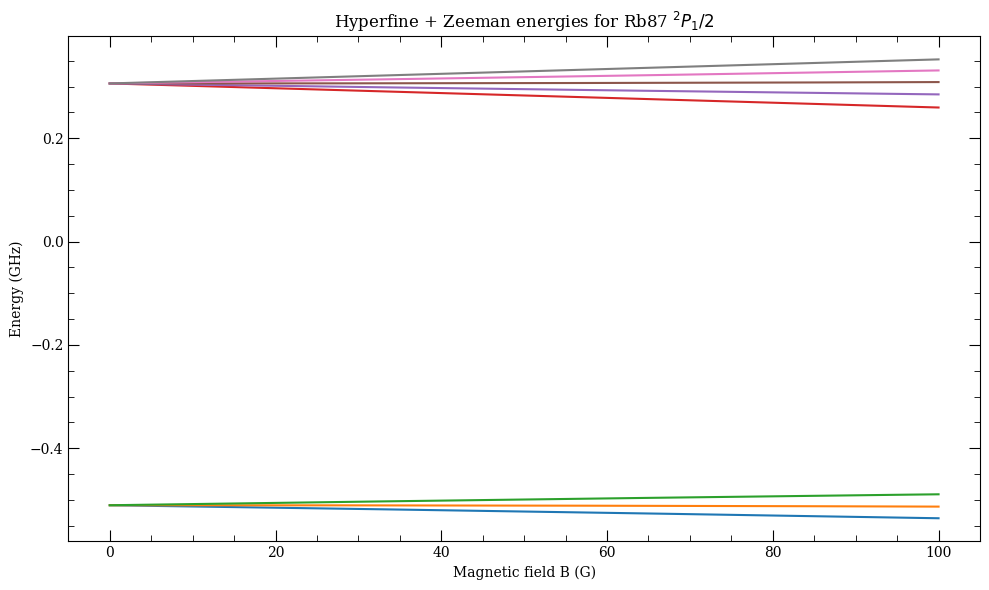

Zero-field eigenvalues (Hz):
 [-5.10410e+08 -5.10410e+08 -5.10410e+08  3.06246e+08  3.06246e+08
  3.06246e+08  3.06246e+08  3.06246e+08]
Basis ordering (mI, mJ):
 [(1.5, 0.5), (1.5, -0.5), (0.5, 0.5), (0.5, -0.5), (-0.5, 0.5), (-0.5, -0.5), (-1.5, 0.5), (-1.5, -0.5)]


In [53]:
## User defined constants ##
atom = arc.Rubidium87()   # pick an atom
n = 5
L = 1
J = 1/2
S = 1/2 # For alkali atoms

# Calculated constants
gJ = lande_gJ(L, S, J, gL=atom.gL, gS=atom.gS)
gI = atom.gI             # nuclear g-factor (dimensionless, for use with μ_N)
I = atom.I              # nuclear spin
print(I)
A_hz, B_hz = atom.getHFSCoefficients(n=n, l=L, j=J) 

B_fields = np.linspace(0.0, 0.01, 201)  # in T
Bs, energies, basis = diagonalize_levels(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_fields=B_fields)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10,6))

for i in range(energies.shape[1]):
    plt.plot(Bs*1e4, energies[:, i]/1e9)
plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
# plt.ylim([2e9,3e9])
plt.title(f"Hyperfine + Zeeman energies for {atom.elementName} ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

# Print zero-field eigenvalues (in Hz) and associated basis list for reference
H0, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=0.0)
eigs0 = la.eigvalsh(H0)
print("Zero-field eigenvalues (Hz):\n", np.sort(np.real(eigs0)))
print("Basis ordering (mI, mJ):\n", basis)

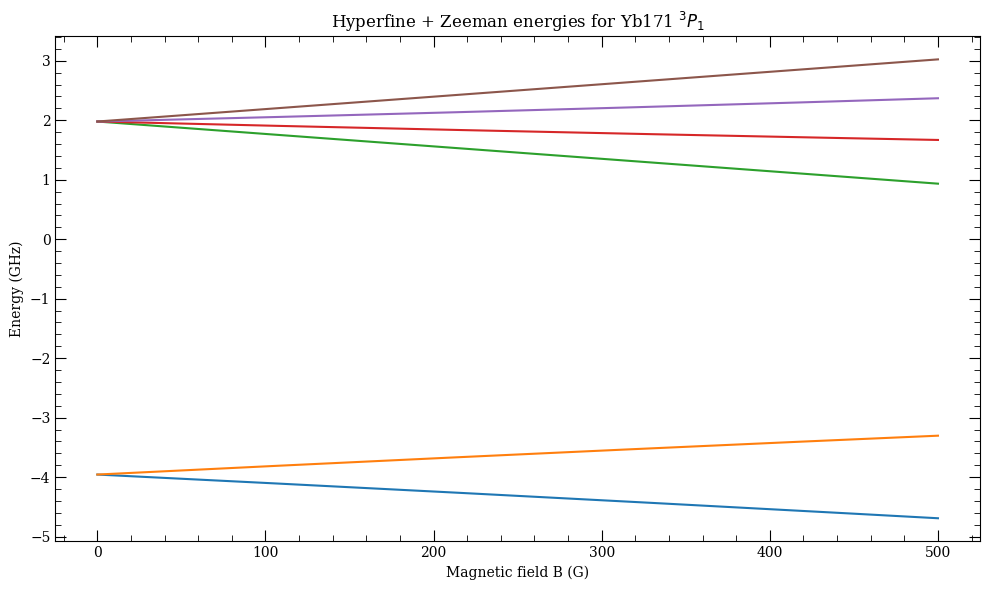

Zero-field eigenvalues (Hz):
 [-3.9570e+09 -3.9570e+09  1.9785e+09  1.9785e+09  1.9785e+09  1.9785e+09]
Basis ordering (mI, mJ):
 [(0.5, 1.0), (0.5, 0.0), (0.5, -1.0), (-0.5, 1.0), (-0.5, 0.0), (-0.5, -1.0)]


In [97]:
## 3P1 Yb171 constants ##
n = 6
L = 1
J = 1
S = 1 # For alkali atoms
gJ = 1.492820  #From https://arxiv.org/html/2509.04416v1
gI = 0.98734 #From https://arxiv.org/html/2509.04416v1
I = 1/2 
A_hz = 3.957e9 #From https://arxiv.org/html/2509.04416v1
B_hz = 0

B_fields = np.linspace(0.0, 0.05, 201) # in T
Bs, energies, basis = diagonalize_levels(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_fields=B_fields)

# Plot energy levels vs B (Hz)
plt.figure(figsize=(10,6))

for i in range(energies.shape[1]):
    plt.plot(Bs*1e4, energies[:, i]/1e9)
plt.xlabel("Magnetic field B (G)")
plt.ylabel("Energy (GHz)")
plt.title(f"Hyperfine + Zeeman energies for Yb171 ${spectroscopic_term(L=L, S=S, J=J)}$")
plt.tight_layout()
plt.show()

# Print zero-field eigenvalues (in Hz) and associated basis list for reference
H0, basis = build_hamiltonian(I, J, A_hz=A_hz, B_hz=B_hz, gJ=gJ, gI=gI, B_field=0.0)
eigs0 = la.eigvalsh(H0)
print("Zero-field eigenvalues (Hz):\n", np.sort(np.real(eigs0)))
print("Basis ordering (mI, mJ):\n", basis)

In [8]:
print(atom.elementName)

Rb87
